In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy

## Real Data: Centrality Measures

Calculating the Unifrom and Structured PageRank centralities as well as the CEC centrality for the data regarding the American revolution, which can be obtained from :  http://konect.cc/networks/brunson_revolution/. Each hyperedge denotes membership of an individual to an activist organisation.


#### Note:

Please see the notebook "erdos_renyi_centrality_correlations.ipynb" for full documentation of the functions used.

In [2]:
from networkx.algorithms import bipartite
g  = nx.Graph()
g.add_nodes_from(['a', 'b', 'c','d','e'], bipartite = 1)
g.add_nodes_from(list(range(6, 137)), bipartite = 0)
mapped = ['a', 'b', 'c','d','e']

In [4]:
import os
os.getcwd()

'C:\\work\\networks\\project'

In [7]:
with open("data/brunson_revolution/out.brunson_revolution_revolution", 'rt') as f: # load in the dataset
    lines = [line.rstrip(' \n') for line in f] 

In [4]:
edges = []

for entry in lines:
    node_2 = mapped[int(entry[-1]) - 1]
    node_1 = int(entry[:-2])
    edges.append((node_1, node_2))

In [5]:
g.add_edges_from(edges)

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


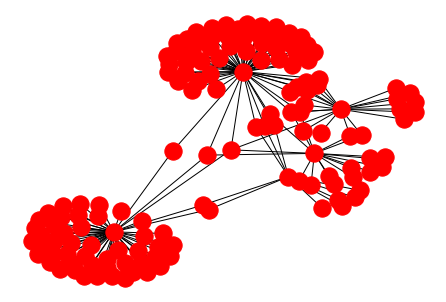

In [6]:
nx.draw(g) #  generate the bipartite network

In [7]:
nx.adj_matrix(g).toarray()

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [8]:
nx.is_connected(g)

True

In [9]:
bottom_nodes, top_nodes = bipartite.sets(g)

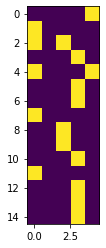

In [10]:
plt.imshow(bipartite.biadjacency_matrix(g, row_order = list(range(6, 137)), column_order= ["a", "b", "c", "d", "e"]).toarray()[:15])

In [11]:
test = bipartite.biadjacency_matrix(g, row_order = list(range(6, 137)), column_order= ["a", "b", "c", "d", "e"]).toarray()[:]

In [12]:
# read biadjacency matrix to hypergraph
H = UndirectedHypergraph()
H.add_nodes(list(range(0, len(test))))

for col in range(len(test[0])):
    # iterating through the hyperedges
    # find the non-zero elements => nodes in the hyperedge
    nodes_in_h_edge = list(np.nonzero(test[:,col])[0])
    print(nodes_in_h_edge)
    if len(nodes_in_h_edge) == 0:
        pass
    else:
        H.add_hyperedge(nodes_in_h_edge)

[1, 2, 4, 7, 11, 15, 18, 19, 20, 21, 22, 24, 25, 28, 29, 35, 39, 40, 47, 49, 53, 56, 58, 59, 64, 65, 67, 70, 74, 76, 78, 80, 85, 86, 87, 88, 90, 96, 97, 100, 101, 103, 104, 108, 109, 110, 111, 113, 114, 116, 119, 120, 125, 129, 130]
[25, 30, 31, 34, 37, 44, 52, 68, 83, 92, 99, 100, 118, 120, 128]
[2, 8, 9, 25, 33, 35, 49, 50, 54, 71, 78, 83, 93, 95, 99, 112, 120, 124, 130]
[3, 5, 6, 10, 12, 13, 14, 16, 17, 23, 27, 32, 36, 38, 41, 43, 45, 46, 48, 51, 55, 57, 60, 61, 62, 63, 66, 69, 72, 73, 75, 77, 79, 81, 82, 84, 89, 91, 94, 98, 100, 102, 105, 107, 115, 119, 120, 121, 122, 123, 126, 127]
[0, 4, 21, 26, 32, 39, 42, 106, 117, 123]


In [13]:
node_map = undirected_matrices.get_node_mapping(H)[1]
edge_map = undirected_matrices.get_hyperedge_id_mapping(H)[1]

I = undirected_matrices.get_incidence_matrix(H, node_map, edge_map).toarray()

In [14]:
# PageRank functions

def power_iteration(A, num_simulations: int):

    # Code taken from "https://en.wikipedia.org/wiki/Power_iteration"
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

def hg_pagerank_power(T, alpha, num_sims):
    nodes = list(range(len(T)))
    n = len(nodes)

    T = alpha*T + (1-alpha)/n*np.ones((n,n)) # PageRank w/ teleportation
    
    res_pgrk = power_iteration(T.T, 100) # power method
    
    return res_pgrk

In [15]:
# Uniform PageRank

gamma = -1

# hyper-adjacency matrix
A = I @ I.T
# hyper-edges matrix
C = I.T @ I

# generate transition matrix for PageRank

C_hat = np.diag(np.diag(C))

K = np.zeros((len(A), len(A)))
C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

K = (I @ C_alt @ I.T).astype(float)
K = K - np.diag(np.diag(K)) # simple walk => remove diagonal entries


T = np.zeros((len(A), len(A)))
for i in range(len(A)):
    norm = np.sum(K[i])
    if norm ==0:
        pass
    else:
        T[i, :] = K[i] / norm

res_pgrk_u = hg_pagerank_power(T, 0.85, 100) # gamma = -1 PageRank

In [24]:
# Structured 

gamma = 1

# hyper-adjacency matrix
A = I @ I.T
# hyper-edges matrix
C = I.T @ I

# generate transition matrix for PageRank

C_hat = np.diag(np.diag(C))

K = np.zeros((len(A), len(A)))
C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

K = (I @ C_alt @ I.T).astype(float)
K = K - np.diag(np.diag(K)) # simple walk => remove diagonal entries


T = np.zeros((len(A), len(A)))
for i in range(len(A)):
    norm = np.sum(K[i])
    if norm ==0:
        pass
    else:
        T[i, :] = K[i] / norm

res_pgrk_s = hg_pagerank_power(T, 0.85, 100) # gamma = 1 PageRank

In [33]:
# CEC centrality

def compute_cec_ranking_power(A, num_sims):
    # implementing the power method
    # code altered from: https://en.wikipedia.org/wiki/Power_iteration
    b_k = np.random.rand(len(A))

    for _ in range(num_sims):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k


res_cec = compute_cec_ranking_power(A, 100) # CEC centrality scores

In [34]:
np.corrcoef([res_cec, res_pgrk_s, res_pgrk_u])

array([[1.        , 0.90607642, 0.49490732],
       [0.90607642, 1.        , 0.63971552],
       [0.49490732, 0.63971552, 1.        ]])

In [35]:
import pandas as pd

df = pd.DataFrame(np.array((res_cec, res_pgrk_s, res_pgrk_u)).T)
df.columns =['CEC', "PG^(1)", "PG^(-1)"]

In [36]:
df.head()

,CEC,PG^(1),PG^(-1)
0,0.000938,0.002043,0.006499
1,0.011166,0.008751,0.006730
2,0.013418,0.010875,0.011984
3,0.006056,0.007856,0.007099
4,0.012104,0.009804,0.012135


In [37]:
print("Correlations between the different centrality measures for gamma = 1 and -1.")
df.corr()

Correlations between the different centrality measures for gamma = 1 and -1.


,CEC,PG^(1),PG^(-1)
CEC,1.000000,0.906076,0.494907
PG^(1),0.906076,1.000000,0.639716
PG^(-1),0.494907,0.639716,1.000000


### Computing the distribution of the centrality scores via density estimates

Text(0.5, 1.0, 'Density Estimate of Centrality Score Distribution')

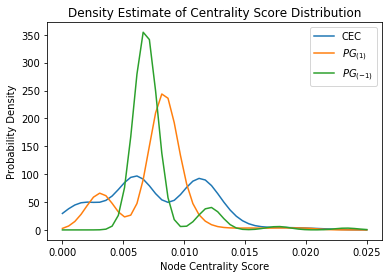

In [50]:
from scipy import stats

positions_cec = np.linspace(0, 0.025)
kernel_cec = stats.gaussian_kde(res_cec)
kde_cec = kernel_cec(positions_cec)

positions_s = np.linspace(0, 0.025)
kernel_s = stats.gaussian_kde(res_pgrk_s)
kde_s = kernel_s(positions_s)

positions_u = np.linspace(0, 0.025)
kernel_u = stats.gaussian_kde(res_pgrk_u)
kde_u = kernel_u(positions_u)


plt.plot(positions_cec, kde_cec)
plt.plot(positions_s, kde_s)
plt.plot(positions_u, kde_u)

plt.legend(["CEC", "$PG_{(1)}$", "$PG_{(-1)}$"])

plt.xlabel("Node Centrality Score")
plt.ylabel("Probability Density")
plt.title("Density Estimate of Centrality Score Distribution")

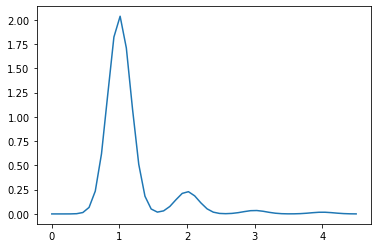

In [59]:
# comparing it to the node degree distribution

stat_dis = []

for node in H.get_node_set():
    stat_dis.append(len(H.get_star(node))) # degree distribution of each node
    
positions_node = np.linspace(0, 4.5)
kernel_node = stats.gaussian_kde(stat_dis)
kde_node = kernel_node(positions_node)
   
    
plt.plot(positions_node, kde_node)

Comment: From inspection, it looks as though $PG_{(-1)}$ matches closely to the node distribution than the others. This means that  $PG_{(-1)}$ is probably node the best measure to use as we could just use the node distribution itself to rank nodes which does not incorporate higher-order interactions. Instead, the CEC and  $PG_{(1)}$ measures look more promising.